# NYC Taxi Fare Prediction

Projet issu du challenge Kaggle : https://www.kaggle.com/c/new-york-city-taxi-fare-predictio
> => The aim of the project is to predict "fare_amount"

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, Lasso

In [4]:
# Import data
# The training set is relatively big. Let's open a portion of it
url = 's3://wagon-public-datasets/taxi-fare-train.csv'
df = pd.read_csv(url, nrows=1_000_000)

In [5]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   key                1000000 non-null  object 
 1   fare_amount        1000000 non-null  float64
 2   pickup_datetime    1000000 non-null  object 
 3   pickup_longitude   1000000 non-null  float64
 4   pickup_latitude    1000000 non-null  float64
 5   dropoff_longitude  999990 non-null   float64
 6   dropoff_latitude   999990 non-null   float64
 7   passenger_count    1000000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 61.0+ MB


# Explore the data

We first need to get a better understanding of the data :
- have a look at the distribution of the variable that we are going to predict: "fare_amount"
- visualize other variable distributions
- compute and visualize the correlation between the target variable and other variables
- lets look for any missing values, or other irregularities

In [10]:
# Define parameters for plt & sns
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 14
plt.figure(figsize=(12,5))
palette = sns.color_palette('Paired', 10)

<Figure size 864x360 with 0 Axes>

## Explore fare_amount

In [11]:
df.fare_amount.describe()

count    1000000.000000
mean          11.348079
std            9.822090
min          -44.900000
25%            6.000000
50%            8.500000
75%           12.500000
max          500.000000
Name: fare_amount, dtype: float64

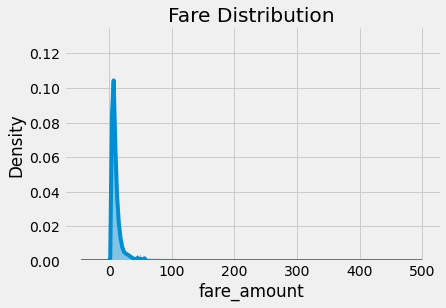

In [12]:
def plot_dist(series=df["fare_amount"], title="Fare Distribution"):
    sns.histplot(series, kde=True, stat='density', discrete=True)
    sns.despine()
    plt.title(title);
    plt.show()
plot_dist()

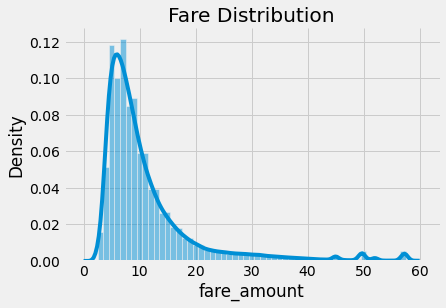

In [13]:
# Let's keep values between 0 - 60$ 
df = df[df.fare_amount.between(0,60)]
plot_dist(df.fare_amount)

In [14]:
# we can also visualize binned fare_amount variable
df['fare-bin'] = pd.cut(df['fare_amount'], bins = list(range(0, 50, 5)), include_lowest=True).astype('str')

# uppermost bin
df['fare-bin'] = df['fare-bin'].replace(np.nan, '[45+]')

# clean up the label of the first bin
df['fare-bin'] = df['fare-bin'].apply(lambda x: x.replace('-0.001', '0'))

# sort by fare the correct look in the chart
df = df.sort_values(by='fare_amount')

/tmp/ipykernel_1550/2364960448.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fare-bin'] = pd.cut(df['fare_amount'], bins = list(range(0, 50, 5)), include_lowest=True).astype('str')
/tmp/ipykernel_1550/2364960448.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fare-bin'] = df['fare-bin'].replace(np.nan, '[45+]')
/tmp/ipykernel_1550/2364960448.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

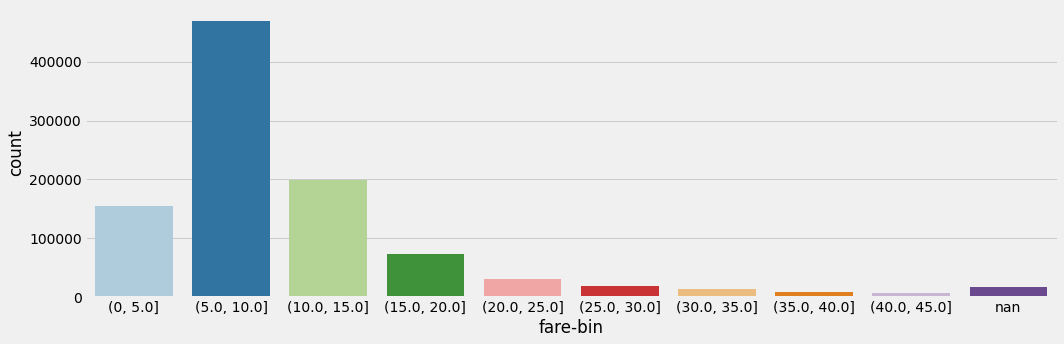

In [15]:
sns.catplot(x="fare-bin", kind="count", palette=palette, data=df, height=5, aspect=3);
sns.despine()
plt.show()

## Explore other variables

In [27]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare-bin
211455,2015-04-15 14:02:39.0000003,0.0,2015-04-15 14:02:39 UTC,-73.937378,40.758450,-73.937447,40.758450,1,"(0, 5.0]"
897211,2015-04-08 00:47:30.0000001,0.0,2015-04-08 00:47:30 UTC,0.000000,0.000000,-73.937698,40.758118,1,"(0, 5.0]"
266485,2010-02-20 09:51:27.0000004,0.0,2010-02-20 09:51:27 UTC,-73.877376,40.772415,-73.877403,40.772391,1,"(0, 5.0]"
689250,2015-05-27 23:10:03.0000004,0.0,2015-05-27 23:10:03 UTC,-73.994125,40.741131,-73.994125,40.741131,1,"(0, 5.0]"
331597,2013-08-05 06:45:54.0000005,0.0,2013-08-05 06:45:54 UTC,-73.982354,40.679971,-73.982354,40.679971,1,"(0, 5.0]"


In [28]:
df.shape

(997297, 9)

### Passenger Count

In [17]:
df.passenger_count.describe()

count    997297.000000
mean          1.685096
std           1.324201
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         208.000000
Name: passenger_count, dtype: float64

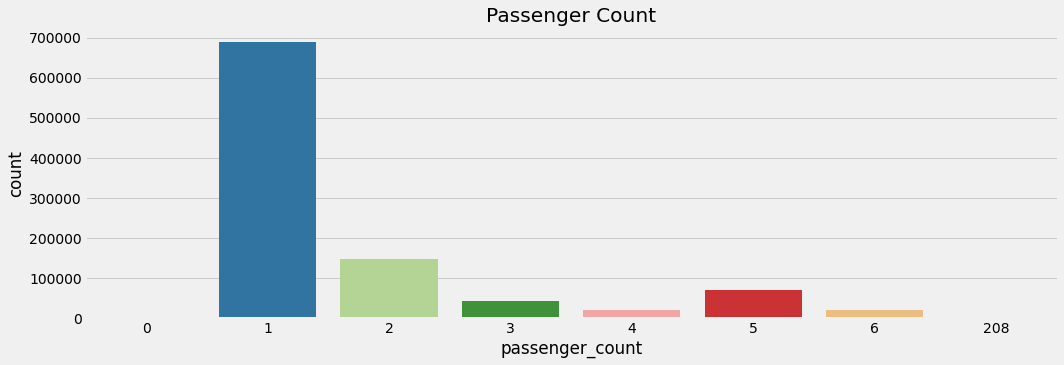

In [26]:
sns.catplot(data=df, x='passenger_count', palette=palette, kind='count', height=5, aspect=3)
plt.title('Passenger Count');

### Pickup datetime

We need to extract time features (hour, day of week, month, year)

In [30]:
def extract_time_features(df):
    timezone_name = 'America/New_York'
    time_column = "pickup_datetime"
    df.index = pd.to_datetime(df[time_column])
    df.index = df.index.tz_convert(timezone_name)
    df["dow"] = df.index.weekday
    df["hour"] = df.index.hour
    df["month"] = df.index.month
    df["year"] = df.index.year
    return df.reset_index(drop=True)

In [31]:
%%time
df = extract_time_features(df)

CPU times: user 1min 49s, sys: 0 ns, total: 1min 49s
Wall time: 1min 49s


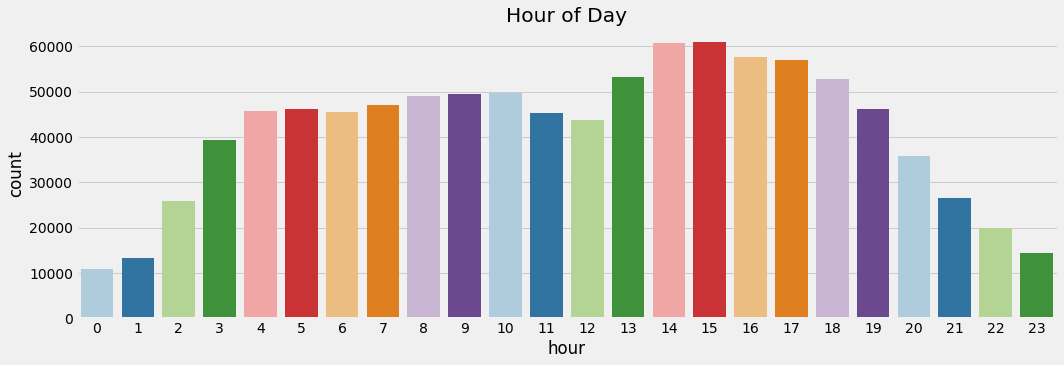

In [32]:
# Hour 
sns.catplot(x="hour", kind="count", palette=palette, data=df, height=5, aspect=3);
plt.title('Hour of Day');

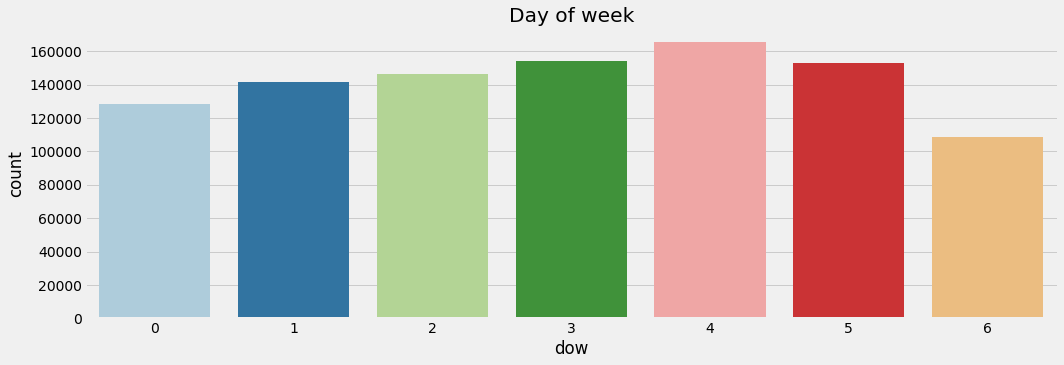

In [35]:
# Day of week (0 = monday, 6 = sunday)
sns.catplot(x="dow", kind="count", palette=palette, data=df, height=5, aspect=3);
plt.title('Day of week');

### Pickup and dropoff locations

In [37]:
df_test = pd.read_csv('data/test.csv')
df_test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [38]:
# find the boudaries from the test set and remove the outliers from the training set
for col in ["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"]:
    MIN = df_test[col].min()
    MAX = df_test[col].max()
    print(col, MIN, MAX)

pickup_latitude 40.573143 41.709555
pickup_longitude -74.252193 -72.986532
dropoff_latitude 40.568973 41.696683
dropoff_longitude -74.263242 -72.990963


In [39]:
df = df[df["pickup_latitude"].between(left = 40, right = 42 )]
df = df[df["pickup_longitude"].between(left = -74.3, right = -72.9 )]
df = df[df["dropoff_latitude"].between(left = 40, right = 42 )]
df = df[df["dropoff_longitude"].between(left = -74, right = -72.9 )]

In [47]:
#Folium map of NYC
center_location = [40.758896, -73.985130]
m = folium.Map(location=center_location, control_scale=True, zoom_start=11)
m

In [46]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare-bin,dow,hour,month,year
0,2015-04-15 14:02:39.0000003,0.0,2015-04-15 14:02:39 UTC,-73.937378,40.758450,-73.937447,40.758450,1,"(0, 5.0]",2,10,4,2015
2,2010-02-20 09:51:27.0000004,0.0,2010-02-20 09:51:27 UTC,-73.877376,40.772415,-73.877403,40.772391,1,"(0, 5.0]",5,4,2,2010
3,2015-05-27 23:10:03.0000004,0.0,2015-05-27 23:10:03 UTC,-73.994125,40.741131,-73.994125,40.741131,1,"(0, 5.0]",2,19,5,2015
4,2013-08-05 06:45:54.0000005,0.0,2013-08-05 06:45:54 UTC,-73.982354,40.679971,-73.982354,40.679971,1,"(0, 5.0]",0,2,8,2013
5,2015-05-26 12:28:03.0000003,0.0,2015-05-26 12:28:03 UTC,-73.986473,40.721909,-73.986473,40.721905,1,"(0, 5.0]",1,8,5,2015


In [49]:
# Heatmap of the rides
df["count"] =1
heatmap_data = df.head(10000)[['pickup_latitude', 'pickup_longitude', 'count']].groupby(['pickup_latitude', 'pickup_longitude']).sum().reset_index().values.tolist()
gradient = {0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}
HeatMap(data=heatmap_data, radius=5, gradient=gradient, max_zoom=13).add_to(m)
m

In [50]:
# Heatmap by hour
heatmap_data_by_hour = []
__df__ = df.head(10000)
for hour in df.hour.sort_values().unique():
    _df = __df__[__df__.hour == hour][['pickup_latitude', 'pickup_longitude', 'count']].groupby(['pickup_latitude', 'pickup_longitude']).sum().reset_index().values.tolist()
    heatmap_data_by_hour.append(_df)

In [51]:
m2 = folium.Map(location=center_location, control_scale=True, zoom_start=11)
HeatMapWithTime(heatmap_data_by_hour, radius=5,
                gradient=gradient,
                min_opacity=0.5, max_opacity=0.8,
                use_local_extrema=False).add_to(m2)
m2

### Distance

In [52]:
# Distance between pickup and dropoff locations usign Haversine distance
def haversine_distance(df,
                       start_lat="start_lat",
                       start_lon="start_lon",
                       end_lat="end_lat",
                       end_lon="end_lon"):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees).
    Vectorized version of the haversine distance for pandas df
    Computes distance in kms
    """

    lat_1_rad, lon_1_rad = np.radians(df[start_lat].astype(float)), np.radians(df[start_lon].astype(float))
    lat_2_rad, lon_2_rad = np.radians(df[end_lat].astype(float)), np.radians(df[end_lon].astype(float))
    dlon = lon_2_rad - lon_1_rad
    dlat = lat_2_rad - lat_1_rad

    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat_1_rad) * np.cos(lat_2_rad) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    haversine_distance = 6371 * c
    return haversine_distance

df["distance"] = haversine_distance(df, 
                                    start_lat="pickup_latitude", start_lon="pickup_longitude",
                                    end_lat="dropoff_latitude", end_lon="dropoff_longitude")

In [53]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare-bin,dow,hour,month,year,count,distance
0,2015-04-15 14:02:39.0000003,0.0,2015-04-15 14:02:39 UTC,-73.937378,40.758450,-73.937447,40.758450,1,"(0, 5.0]",2,10,4,2015,1,0.005783
2,2010-02-20 09:51:27.0000004,0.0,2010-02-20 09:51:27 UTC,-73.877376,40.772415,-73.877403,40.772391,1,"(0, 5.0]",5,4,2,2010,1,0.003506
3,2015-05-27 23:10:03.0000004,0.0,2015-05-27 23:10:03 UTC,-73.994125,40.741131,-73.994125,40.741131,1,"(0, 5.0]",2,19,5,2015,1,0.000000
4,2013-08-05 06:45:54.0000005,0.0,2013-08-05 06:45:54 UTC,-73.982354,40.679971,-73.982354,40.679971,1,"(0, 5.0]",0,2,8,2013,1,0.000000
5,2015-05-26 12:28:03.0000003,0.0,2015-05-26 12:28:03 UTC,-73.986473,40.721909,-73.986473,40.721905,1,"(0, 5.0]",1,8,5,2015,1,0.000424


In [54]:
df.distance.describe()

count    847916.000000
mean          3.288393
std           3.717411
min           0.000000
25%           1.236222
50%           2.112549
75%           3.837169
max         104.254968
Name: distance, dtype: float64

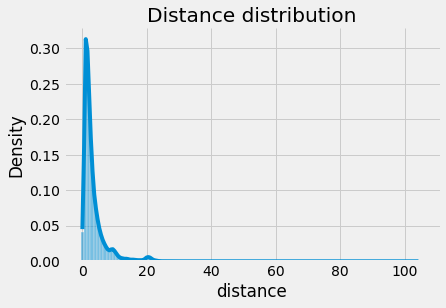

In [55]:
plot_dist(series=df.distance, title='Distance distribution')

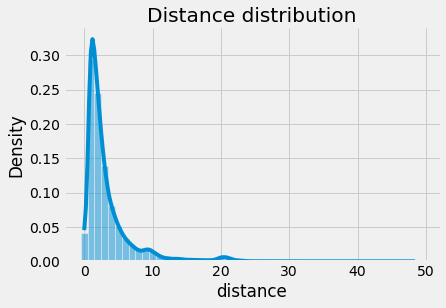

In [59]:
# Focus distance < 50 
plot_dist(series=df[df.distance < 50].distance, title='Distance distribution')

### Correlation between the target and other variables

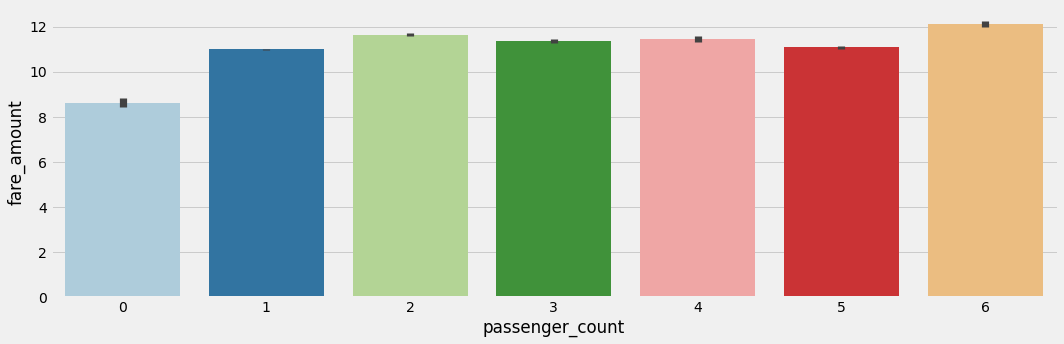

In [61]:
# Correlation with passenger count
sns.catplot(x="passenger_count", y="fare_amount", palette=palette, data=df, kind="bar", aspect=3)
sns.despine()
plt.show()

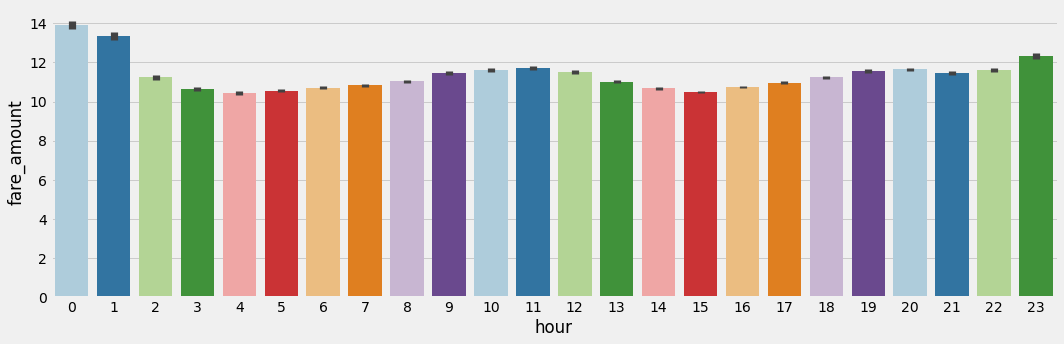

In [62]:
# Correlation with hour of the day
sns.catplot(x="hour", y="fare_amount", palette=palette, data=df, kind="bar", aspect=3)
sns.despine()
plt.show()

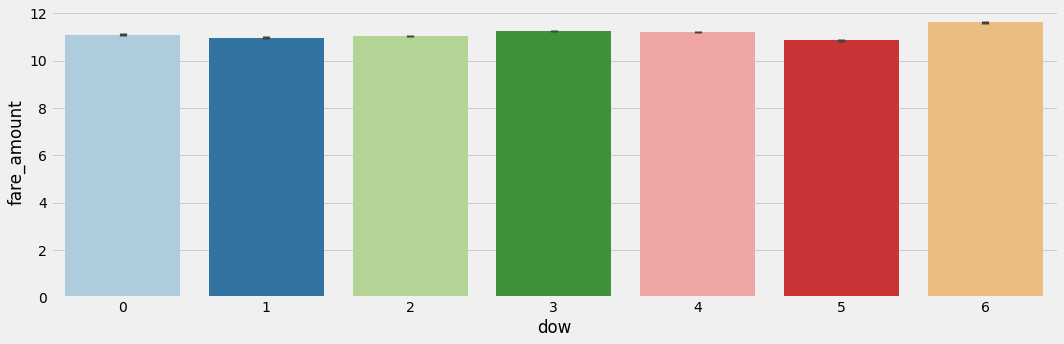

In [63]:
# Correlation with day of the week
sns.catplot(x="dow", y="fare_amount", palette=palette, data=df, kind="bar", aspect=3)
sns.despine()
plt.show()

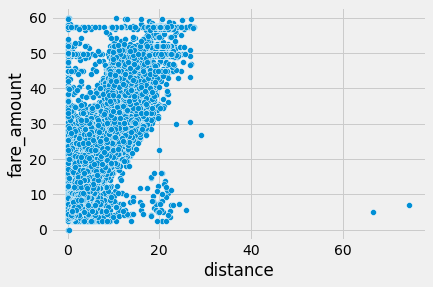

In [64]:
# Correlation with distance
sns.scatterplot(x="distance", y="fare_amount", data=df[df.distance < 80].sample(100000))
plt.show()

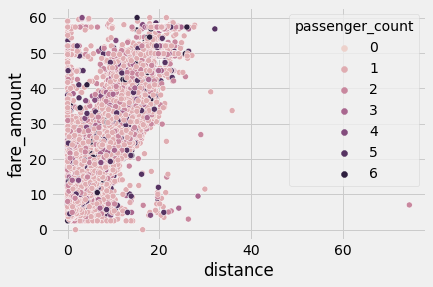

In [65]:
sns.scatterplot(x="distance", y="fare_amount", hue="passenger_count", data=df[df.distance < 80].sample(100000))
plt.show()

# Data cleaning

In [66]:
df.shape

(847916, 15)

In [67]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare-bin,dow,hour,month,year,count,distance
0,2015-04-15 14:02:39.0000003,0.0,2015-04-15 14:02:39 UTC,-73.937378,40.758450,-73.937447,40.758450,1,"(0, 5.0]",2,10,4,2015,1,0.005783
2,2010-02-20 09:51:27.0000004,0.0,2010-02-20 09:51:27 UTC,-73.877376,40.772415,-73.877403,40.772391,1,"(0, 5.0]",5,4,2,2010,1,0.003506
3,2015-05-27 23:10:03.0000004,0.0,2015-05-27 23:10:03 UTC,-73.994125,40.741131,-73.994125,40.741131,1,"(0, 5.0]",2,19,5,2015,1,0.000000
4,2013-08-05 06:45:54.0000005,0.0,2013-08-05 06:45:54 UTC,-73.982354,40.679971,-73.982354,40.679971,1,"(0, 5.0]",0,2,8,2013,1,0.000000
5,2015-05-26 12:28:03.0000003,0.0,2015-05-26 12:28:03 UTC,-73.986473,40.721909,-73.986473,40.721905,1,"(0, 5.0]",1,8,5,2015,1,0.000424


In [70]:
# Values that do not seem valid
print("trips with negative fares:", len(df[df.fare_amount <= 0]))
print("trips with too high distance:", len(df[df.distance >= 100]))
print("trips with too many passengers:", len(df[df.passenger_count > 8]))
print("trips with zero passenger:", len(df[df.passenger_count == 0]))

trips with negative fares: 18
trips with too high distance: 16
trips with too many passengers: 0
trips with zero passenger: 2999


In [71]:
df.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'fare-bin', 'dow', 'hour', 'month', 'year', 'count',
       'distance'],
      dtype='object')

In [81]:
# Clean data
def clean_data(df):
    df = df.dropna(how='any', axis=0)
    df = df[(df.dropoff_longitude != 0) | (df.dropoff_latitude != 0)]
    df = df[(df.pickup_longitude != 0) | (df.pickup_latitude != 0)]
    df = df[df.fare_amount.between(0,60)]
    df = df[df.passenger_count < 8]
    df = df[df.passenger_count >= 0]
    df = df[df["pickup_latitude"].between(40, 42)]
    df = df[df["pickup_longitude"].between(-74.3, -72.9 )]
    df = df[df["dropoff_latitude"].between(40, 42)]
    df = df[df["dropoff_longitude"].between(-74, -72.9)]
    return df

In [82]:
df_clean = clean_data(df)
"% data removed", (1 - len(df_clean) / len(df))*100

('% data removed', 0.0)

In [83]:
df_clean.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare-bin,dow,hour,month,year,count,distance
0,2015-04-15 14:02:39.0000003,0.0,2015-04-15 14:02:39 UTC,-73.937378,40.758450,-73.937447,40.758450,1,"(0, 5.0]",2,10,4,2015,1,0.005783
2,2010-02-20 09:51:27.0000004,0.0,2010-02-20 09:51:27 UTC,-73.877376,40.772415,-73.877403,40.772391,1,"(0, 5.0]",5,4,2,2010,1,0.003506
3,2015-05-27 23:10:03.0000004,0.0,2015-05-27 23:10:03 UTC,-73.994125,40.741131,-73.994125,40.741131,1,"(0, 5.0]",2,19,5,2015,1,0.000000
4,2013-08-05 06:45:54.0000005,0.0,2013-08-05 06:45:54 UTC,-73.982354,40.679971,-73.982354,40.679971,1,"(0, 5.0]",0,2,8,2013,1,0.000000
5,2015-05-26 12:28:03.0000003,0.0,2015-05-26 12:28:03 UTC,-73.986473,40.721909,-73.986473,40.721905,1,"(0, 5.0]",1,8,5,2015,1,0.000424


In [84]:
df.shape, df_clean.shape

((847916, 15), (847916, 15))

# Evaluation metric

The evaluation metric for this competition is the root mean-squared error or RMSE. The RMSE measures the difference between the predictions of a model, and the corresponding ground truth. A large RMSE is equivalent to a large average error, so smaller values of RMSE are better.

In [85]:
# Method that compute the RMSE
def compute_rmse(y_pred, y_true):
    return np.sqrt(((y_pred - y_true)**2).mean())

# Model baseline

In [87]:
# Our basline could be the mean of fare_amount
df['y_pred'] = df_clean['fare_amount'].mean()
df['y_pred'][0]

11.136315342557516

In [88]:
compute_rmse(df['y_pred'], df['fare_amount'])

8.989136548959618

# Model

In [92]:
# Train test split dataset
df_train, df_test = train_test_split(df, test_size=0.1)

In [93]:
# Apply data cleaning
df_train = clean_data(df_train)

In [94]:
df_train.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'fare-bin', 'dow', 'hour', 'month', 'year', 'count',
       'distance', 'y_pred'],
      dtype='object')

In [95]:
# Features we want to use in  the model
target = 'fare_amount'
features = ['distance', 'hour', 'dow', 'passenger_count']
cat_feat = ['hour', 'dow', 'passenger_count']

In [96]:
df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare-bin,dow,hour,month,year,count,distance,y_pred
885832,2013-05-09 10:10:00.000000197,19.0,2013-05-09 10:10:00 UTC,-73.994702,40.750460,-73.960322,40.779117,6,"(15.0, 20.0]",3,6,5,2013,1,4.305510,11.136315
181393,2012-07-08 17:45:48.0000004,5.3,2012-07-08 17:45:48 UTC,-73.975956,40.759039,-73.985476,40.757500,2,"(5.0, 10.0]",6,13,7,2012,1,0.819898,11.136315
58597,2011-11-09 20:34:45.0000002,4.1,2011-11-09 20:34:45 UTC,-73.976333,40.751272,-73.980536,40.743568,1,"(0, 5.0]",2,15,11,2011,1,0.926932,11.136315
512280,2012-03-27 02:12:06.0000002,8.5,2012-03-27 02:12:06 UTC,-73.959858,40.773708,-73.991712,40.749721,1,"(5.0, 10.0]",0,22,3,2012,1,3.783078,11.136315
524716,2013-04-15 13:14:11.0000003,8.5,2013-04-15 13:14:11 UTC,-73.954113,40.774568,-73.972479,40.759879,1,"(5.0, 10.0]",0,9,4,2013,1,2.249466,11.136315


In [105]:
# Features transformation
def transform_feat(_df, dummy_feat=None):
    encode = True if dummy_feat is None else False
    dummy_feat = dummy_feat if dummy_feat is not None else []
    for c in cat_feat:
        dummies = pd.get_dummies(_df[c], prefix=c)
        _df = pd.concat([_df, dummies], axis=1)
        if encode:
            dummy_feat = dummy_feat + (list(dummies.columns.values))
    for dummy_feature in [f for f in dummy_feat if f not in _df.columns]:
        _df[dummy_feature] = 0 
    _df = _df[dummy_feat + features]
    return _df, dummy_feat

In [106]:
# X_train, y_train
X_train, dummy_feat = transform_feat(df_train)
X_train = df_train[features]
y_train = df_train['fare_amount']

# LassoCV model
model = LassoCV(cv=5, n_alphas=5)
# Fit model
model.fit(X_train, y_train)

LassoCV(cv=5, n_alphas=5)

In [108]:
# Model evaluation
X_test = df_test[features]
df_test['y_pred'] = model.predict(X_test)
compute_rmse(df_test['y_pred'], df_test['fare_amount'])

4.56651690769221

The RMSE is lower than the baseline with the LassoCV model.

# Kaggle submission

In [110]:
# Train model with all data
df_clean = clean_data(df)
X = df_clean[features]
y = df_clean['fare_amount']

model_lasso = Lasso(alpha=5)
model_lasso.fit(X,y)

Lasso(alpha=5)

In [133]:
# Load test dataset from Kaggle
df_test = pd.read_csv('data/test.csv')
df_test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [134]:
df_test.columns

Index(['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [135]:
# Feature eng
df_test['distance'] = haversine_distance(df_test, start_lat="pickup_latitude", start_lon="pickup_longitude", end_lat="dropoff_latitude", end_lon="pickup_longitude")

In [136]:
df_test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1,2.220556
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1,2.203589
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1,0.569429
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1,1.798244
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1,5.042468


In [137]:
%%time
df_test = extract_time_features(df_test)

CPU times: user 262 ms, sys: 10.3 ms, total: 273 ms
Wall time: 269 ms


In [138]:
# Define X
X_test = df_test[features]

# Prediction
df_test['y_pred'] = model_lasso.predict(X_test)
df_test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,dow,hour,month,year,y_pred
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1,2.220556,1,8,1,2015,9.329551
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1,2.203589,1,8,1,2015,9.300843
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1,0.569429,5,7,10,2011,6.535868
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1,1.798244,5,16,12,2012,8.615006
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1,5.042468,5,16,12,2012,14.104184


In [140]:
# For Kaggle submission : Key, fare_amount
df_test.reset_index(drop=True)[['key', 'y_pred']].rename(columns={'y_pred': 'fare_amount'}).to_csv('lasso_v1_prediction.csv', index=False)

My first Kaggle score => 7.5